<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/scrape_coc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install upgrade chromedriver

In [162]:
# install chromium, its driver
!apt-get update
!apt install chromium-chromedriver

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 2s (127 kB/s)
Reading package lists... Done
Reading package lists... Done
Building de

In [163]:
# install selenium

!pip install selenium

# Library Imports

In [165]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

import nltk
import string
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger','vader_lexicon'])
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Chrome Webdriver

In [0]:

# set options to be headless, ..


options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)



In [0]:
# Selenium script to scroll to the bottom, wait 3 seconds for the next batch of data to load, then continue scrolling.  
# It will continue to do this until the page stops loading new data.
url = 'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'
driver.get(url)
lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight); var lenOfPage=document.body.scrollHeight; return lenOfPage;")
match=False
while(match==False):
  lastCount = lenOfPage
  time.sleep(10)
  lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
  if lastCount==lenOfPage:
    match=True

In [168]:
lenOfPage

36236

In [169]:
driver.current_url

'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'

In [115]:
bu = driver.find_elements_by_css_selector('button.LkLjZd.ScJHi.OzU4dc')

len(bu)

17

In [179]:
bu1 = driver.find_elements_by_css_selector('button.RveJvd.snByac')


len(bu1)

0

In [170]:
for item in bu:
  time.sleep(10)
  item.click()
  time.sleep(10)

ElementClickInterceptedException: ignored

In [171]:
driver.current_url

'https://play.google.com/store/apps/details?id=com.supercell.clashofclans&showAllReviews=true'

# Scrape reviews

In [172]:
reviewer = []
review_date = []
i = 0

review_info = {}
for item in driver.find_elements_by_css_selector('div.bAhLNe.kx8XBd'):
  reviewer.append(item.text)

helpful_reviews = driver.find_elements_by_css_selector('div.jUL89d.y92BAb')
abridged_review = driver.find_elements(by='xpath',value="//span[@jsname='bN97Pc']")
full_reviews  = driver.find_elements(by='xpath',value="//span[@jsname='fbQN7e']")
stars = driver.find_elements(by='xpath',value="//span[@class='nt2C1d']//div//div[@role='img']")
print(len(reviewer),len(abridged_review), len(full_reviews), len(helpful_reviews),len(stars))

200 200 200 200 200


In [0]:

all_reviews = []
for i, (r, a, f, h, s) in enumerate(zip(reviewer, abridged_review,full_reviews, helpful_reviews, stars )):
  review_info = {}
  review_info.update({'id':i, \
                      'name':r.split('\n')[0], \
                      'review_date':r.split('\n')[1], \
                      'abridged_review': a.text, \
                      'full_review': f.text, \
                      'helpful_review': h.text, \
                      'stars':re.findall(r"\d",s.get_attribute('aria-label'))[0]})
  all_reviews.append(review_info)


In [174]:
df_review = pd.DataFrame(all_reviews)
df_review.info()
df_review['review_date'] = df_review['review_date'].apply(lambda x: pd.datetime.strptime(x, '%B %d, %Y'))
df_review['helpful_review'] = pd.to_numeric(df_review['helpful_review'], errors='coerce')
df_review['stars'] = df_review['stars'].astype('int8') 
df_review.info()
df_review.head()
df_review.drop(columns=['full_review'],inplace=True)
df_review.info()
df_review.head()
df_review.drop(columns=['id'],inplace=True)
df_review.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
id                 200 non-null int64
name               200 non-null object
review_date        200 non-null object
abridged_review    200 non-null object
full_review        200 non-null object
helpful_review     200 non-null object
stars              200 non-null object
dtypes: int64(1), object(6)
memory usage: 11.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
id                 200 non-null int64
name               200 non-null object
review_date        200 non-null datetime64[ns]
abridged_review    200 non-null object
full_review        200 non-null object
helpful_review     189 non-null float64
stars              200 non-null int8
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1), object(3)
memory usage: 9.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 column

,name,review_date,abridged_review,helpful_review,stars
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",488.0,4
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,33.0,3
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,36.0,3
3,Brady Ashworth,2019-11-09,THIS GAME IS AMAZING!!!!! I love the way that ...,67.0,5
4,Derek R,2019-11-15,"They took away the Global Chat, which allowed ...",64.0,1


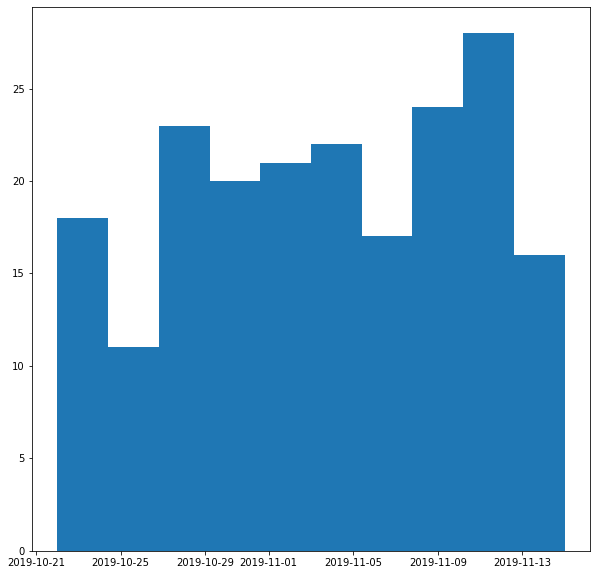

In [175]:
plt.figure(figsize=(10,10))
plt.hist(df_review['review_date'])
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


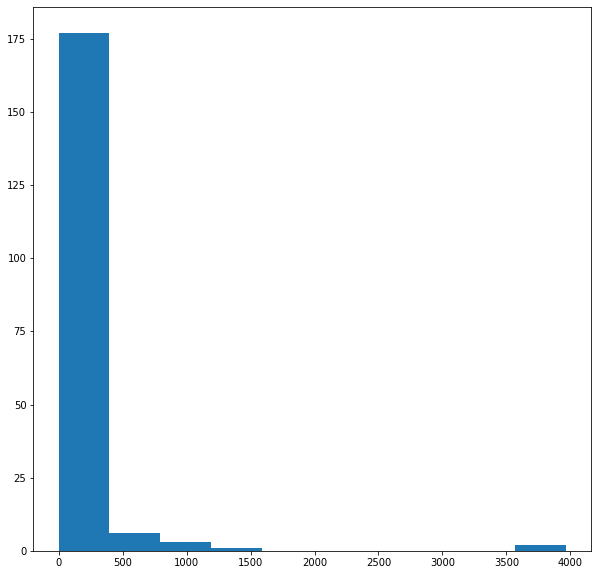

In [176]:
plt.figure(figsize=(10,10))
plt.hist(df_review['helpful_review'])
plt.show()

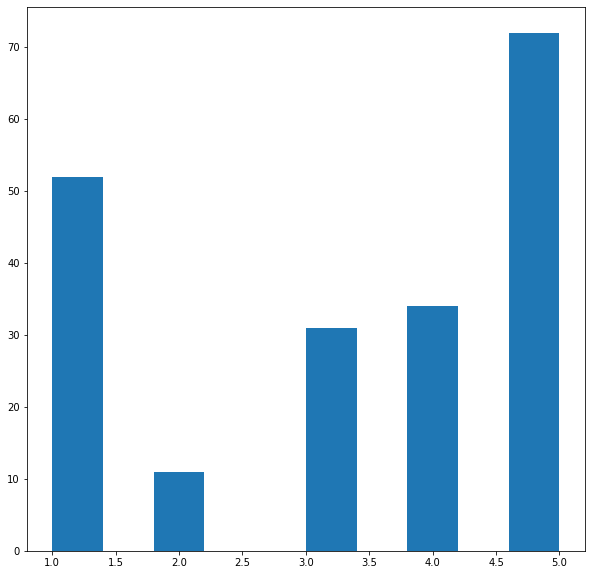

In [177]:
plt.figure(figsize=(10,10))
plt.hist(df_review['stars'])
plt.show()

# Scrape Responses

In [0]:
dates = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']//div[2]//span[@class='p2TkOb']")
person = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']//div[2]//span[@class='X43Kjb']")
all_comms = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']")

In [0]:
dates = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']//div[2]//span[@class='p2TkOb']")
person = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']//div[2]//span[@class='X43Kjb']")
all_comms = driver.find_elements(by='xpath',value="//div[@class='LVQB0b']")


all_responses = []
for i, (d, p, a) in enumerate(zip(dates, person, all_comms)):
  response_info = {}
  response_info.update({'id':i, \
                      'responder_name':p.text, \
                      'response_date':d.text, \
                      'response_text':a.text.split('\n')[1]})
  all_responses.append(response_info)

In [126]:
df_response = pd.DataFrame(all_responses)
df_response['response_date'] = df_response['response_date'].apply(lambda x: pd.datetime.strptime(x, '%B %d, %Y'))
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 4 columns):
id                165 non-null int64
responder_name    165 non-null object
response_date     165 non-null datetime64[ns]
response_text     165 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.3+ KB


In [127]:
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 4 columns):
id                165 non-null int64
responder_name    165 non-null object
response_date     165 non-null datetime64[ns]
response_text     165 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.3+ KB


In [129]:
df_response.drop(columns=['id','responder_name'],inplace=True)
df_response.head(10)

,response_date,response_text
0,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮
1,2019-10-29,We are so glad you found the app! Thanks for y...
2,2019-11-15,We are happy to help on your travels! Thanks f...
3,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜
4,2019-09-07,"Hi Kerry, thanks for your feedback. When searc..."
5,2019-11-12,We are happy to help you on your travels! Than...
6,2019-10-11,"Hi, thanks for your feedback. We only allow fu..."
7,2019-10-28,"Hi Elliot, we'd love to offer everything for f..."
8,2019-09-16,"Hi Julia, we are happy to be worldwide! Thanks..."
9,2019-10-24,Thank you for taking the time to rate us 🐮💜 We...


# Combine Reviews and Responses

In [178]:
df_review.query('review_date > "2019-10-30"')

,name,review_date,abridged_review,helpful_review,stars
0,Beast Stocker21,2019-11-10,"Genuinely, Strategy is the key factor of this ...",488.0,4
1,jonathan biscuit,2019-11-11,I would have gave this 5 stars but their are t...,33.0,3
2,Jeffrey Bach,2019-11-11,Still an amazing game after all these years. I...,36.0,3
3,Brady Ashworth,2019-11-09,THIS GAME IS AMAZING!!!!! I love the way that ...,67.0,5
4,Derek R,2019-11-15,"They took away the Global Chat, which allowed ...",64.0,1
...,...,...,...,...,...
191,Gag Nesh,2019-11-11,I really love this game nd I am crazy for it.....,16.0,5
193,Pawan Kumar,2019-11-04,"Hey Supercell, I've been playing this game sin...",NaN,5
194,shishir sharma,2019-11-02,Good game but coc is cheating its user I got r...,NaN,1
197,THDevil,2019-11-09,"Amazing game, Great Quality, it's like a tycoo...",19.0,5


In [28]:
df_review.loc[:11]

,name,review_date,abridged_review,helpful_review,stars
0,Jared Thresher,2019-10-25,Loving the concept of this app. Even without t...,3.0,4
1,Yoga Ong,2019-10-08,"Overall considered not bad, it is good that ha...",1.0,4
2,Shweta Ramanujam,2019-10-14,Been using this app for a while now.Apart from...,8.0,5
3,eclipse9871,2019-10-16,Love this app especially because it allows use...,6.0,5
4,Jonny Marshall,2019-10-06,Fantastic app. Great resource which is useful ...,NaN,5
5,Theresa Salchert,2019-10-16,"I really love this app. Very easy to use, grea...",NaN,5
6,Lee Sheng Chua,2019-09-16,Love how this app binds people of same beliefs...,1.0,5
7,Joy Rose,2019-09-26,A great app with a great mission. I've donated...,1.0,5
8,Hazel Sim,2019-10-16,If you're finding it hard to dine out with fri...,NaN,5
9,Libby Wongstein,2019-10-05,Love the concept of this app. Easy to use and ...,NaN,5


In [29]:
df_review.loc[13:62]

,name,review_date,abridged_review,helpful_review,stars
13,marisa b,2019-10-07,Great app 👍 it's different from Happy Cow beca...,1.0,5
14,Candy Daitch,2019-10-11,Love this app! Very easy to use and very helpf...,NaN,5
15,Marinette Coertzen,2019-10-01,LOVE this app so much! So many good causes to ...,NaN,5
16,Melanie Martina,2019-09-18,Excellent app! I love that I can help raise fu...,NaN,5
17,Crystal H,2019-10-23,Great app that encourages me to eat more vegan...,NaN,5
18,Riante du Toit,2019-09-16,Easy to use. Great for reviewing vegan product...,NaN,5
19,Lobo Lobo,2019-10-01,Unfortunately it does not have a more up to da...,1.0,1
20,Bushra Amin,2019-10-11,"Clicked ""sign up"" and nothing happened. Tried ...",7.0,1
21,Jay Laone,2019-08-20,I like the idea! I think it's a little hard to...,NaN,3
22,Montse GA,2019-09-18,It's super useful for you and you get to help ...,NaN,5


In [31]:
df_review.loc[64:68]

,name,review_date,abridged_review,helpful_review,stars
64,Em Perez,2019-07-27,Downloaded this and theres no vegan or vegetar...,1.0,1
65,Kartik Verma,2019-07-13,I have no idea what the app is about. It's ver...,1.0,1
66,Michał Połaski,2019-05-17,Excellent way to help your chosen sanctuaries!,1.0,4
67,Lin Min Htoo,2019-02-22,Possible Possible today Possible to Possible t...,1.0,5
68,Danielle-Taylor Fleury,2018-11-09,Super cool app#,2.0,5


In [32]:
df_review.loc[70:]

,name,review_date,abridged_review,helpful_review,stars
70,PrX Nation,2019-10-13,Super fun!,NaN,5
71,Paloma Yury,2019-07-15,Es maravillosa la comunidad que se esta constr...,NaN,5
72,Lee Choon Chong,2019-04-20,Hope that this will help me make healthier foo...,3.0,5
73,RJT KMR,2019-05-17,wow,1.0,5
74,Jim Mount,2018-09-06,"A great app, with it's heart in the right plac...",4.0,5
75,A Google user,2018-09-06,This app is a really great tool where vegans c...,4.0,5
76,Rebecca Tay,2018-08-28,I am able to find restaurants near me that off...,3.0,5
77,Sharon Bates,2018-09-10,I love that this app allows reviews of food at...,2.0,5
78,Kai Wong,2018-08-24,I am unable to upload pictures of the dishes (...,3.0,3
79,Tyler Zachocki,2018-09-11,I use a Samsung galaxy s7 and am unable to pos...,1.0,4


In [33]:
pd.concat([df_review.loc[12],df_review.loc[63],df_review.loc[69] ],axis=1).T.reset_index(drop=True)

,name,review_date,abridged_review,helpful_review,stars
0,caiyun Xu,2019-10-31,"It's a useful app. We can share our reviews, e...",NaN,5
1,Sibel Şendere,2019-11-11,I reviewed 10 vegan products and this app dona...,NaN,5
2,Mohd azman Bin omar,2019-11-15,O.K.,NaN,4


In [0]:
df_review_updated = df_review

In [0]:
df_review_updated = pd.concat([df_review.loc[:11],\
                               df_review.loc[13:62],\
                               df_review.loc[64:68],\
                               df_review.loc[70:],\
                               pd.concat([df_review.loc[12],\
                                          df_review.loc[63],\
                                          df_review.loc[69]],\
                                         axis=1).T.reset_index(drop=True)],\
                              axis=0,\
                              ignore_index=True)

In [35]:
df_review_updated.tail()


,name,review_date,abridged_review,helpful_review,stars
88,Pragnya Roy,2019-05-08,Bill,1,5
89,Rishabh Goyal,2018-05-06,Great app,1,5
90,caiyun Xu,2019-10-31,"It's a useful app. We can share our reviews, e...",NaN,5
91,Sibel Şendere,2019-11-11,I reviewed 10 vegan products and this app dona...,NaN,5
92,Mohd azman Bin omar,2019-11-15,O.K.,NaN,4


In [133]:
df_review_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
name               200 non-null object
review_date        200 non-null datetime64[ns]
abridged_review    200 non-null object
helpful_review     140 non-null float64
stars              200 non-null int8
dtypes: datetime64[ns](1), float64(1), int8(1), object(2)
memory usage: 6.6+ KB


In [0]:
df_review_updated['helpful_review'] = pd.to_numeric(df_review_updated['helpful_review'], errors='coerce')
df_review_updated['stars'] = df_review_updated['stars'].astype('int8') 

In [135]:
df_review_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
name               200 non-null object
review_date        200 non-null datetime64[ns]
abridged_review    200 non-null object
helpful_review     140 non-null float64
stars              200 non-null int8
dtypes: datetime64[ns](1), float64(1), int8(1), object(2)
memory usage: 6.6+ KB


In [136]:
df_review_updated.head()

,name,review_date,abridged_review,helpful_review,stars
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3


In [0]:
df_full = pd.concat([df_review_updated, df_response],axis=1)

In [138]:
df_full.head()

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5,2019-10-29,We are so glad you found the app! Thanks for y...
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3,2019-09-07,"Hi Kerry, thanks for your feedback. When searc..."


In [139]:
df_full.tail()

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text
195,A Google user,2018-07-30,Unable to detect GPS/Location. Too hard to set...,1.0,1,NaT,NaN
196,Stavros Marinos,2018-08-04,This app saved me in my trip to Paris where yo...,2.0,5,NaT,NaN
197,Richard Castro,2018-07-15,Love the app! More Vegans is awesome!,4.0,5,NaT,NaN
198,Olaruci,2018-07-12,Good tool for a vegan in an unknown city.,2.0,5,NaT,NaN
199,berserker nineonetwo,2018-08-28,This app was a lifesaver when I was in Japan.,1.0,5,NaT,NaN


In [0]:
df_full.to_csv('full_review_details.csv')


# NLP Analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    try:
      text = str(text).lower()
    except:
      text = ''.join(re.findall(r"\D",str(text))).lower()


    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    #text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [0]:
df_full['clean_reviews'] = df_full['abridged_review'].apply(lambda x: clean_text(x))
df_full['clean_response'] = df_full['response_text'].apply(lambda x: clean_text(x))

In [142]:
df_full.head()

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮,amazing app date restaurant listings descripti...,thanks emily appreciate kind words 😊🐮
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5,2019-10-29,We are so glad you found the app! Thanks for y...,pure awesomeness year ago miserable trip abroa...,glad found app thanks kind words 🐮💜
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...,great app easy use helpful information must ve...,happy help travels thanks support tracey 🐮💜
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜,excellent resource finding vegan businesses lo...,thanks star review bernadette 🐮💜
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3,2019-09-07,"Hi Kerry, thanks for your feedback. When searc...",app great think need invest bit smarter regard...,hi kerry thanks feedback searching large locat...


In [143]:
df_full.tail()

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response
195,A Google user,2018-07-30,Unable to detect GPS/Location. Too hard to set...,1.0,1,NaT,NaN,unable detect gps/location hard set position,nan
196,Stavros Marinos,2018-08-04,This app saved me in my trip to Paris where yo...,2.0,5,NaT,NaN,app saved trip paris could rarely find somethi...,nan
197,Richard Castro,2018-07-15,Love the app! More Vegans is awesome!,4.0,5,NaT,NaN,love app vegans awesome,nan
198,Olaruci,2018-07-12,Good tool for a vegan in an unknown city.,2.0,5,NaT,NaN,good tool vegan unknown city,nan
199,berserker nineonetwo,2018-08-28,This app was a lifesaver when I was in Japan.,1.0,5,NaT,NaN,app lifesaver japan,nan


In [144]:


df_full.head(20)

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮,amazing app date restaurant listings descripti...,thanks emily appreciate kind words 😊🐮
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5,2019-10-29,We are so glad you found the app! Thanks for y...,pure awesomeness year ago miserable trip abroa...,glad found app thanks kind words 🐮💜
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...,great app easy use helpful information must ve...,happy help travels thanks support tracey 🐮💜
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜,excellent resource finding vegan businesses lo...,thanks star review bernadette 🐮💜
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3,2019-09-07,"Hi Kerry, thanks for your feedback. When searc...",app great think need invest bit smarter regard...,hi kerry thanks feedback searching large locat...
5,Ganesh Chandrasekaran,2019-11-08,"Very useful, they do worldwide. Very use ful w...",3.0,5,2019-11-12,We are happy to help you on your travels! Than...,useful worldwide use ful travel non english sp...,happy help travels thanks part community 😊🐮
6,ShokoSahnex33,2019-10-11,It's a very helpful app. It shows you the clos...,4.0,5,2019-10-11,"Hi, thanks for your feedback. We only allow fu...",helpful app shows closest restaurants either l...,hi thanks feedback allow full star ratings com...
7,Elliot Brooke,2019-10-28,You have to have the paid version to bookmark ...,NaN,1,2019-10-28,"Hi Elliot, we'd love to offer everything for f...",paid version bookmark things also giving stars...,hi elliot we'd love offer everything free cost...
8,Julia A,2019-09-16,"Sooo useful, plus it works in Europe and the U...",8.0,5,2019-09-16,"Hi Julia, we are happy to be worldwide! Thanks...",sooo useful plus works europe usa try countrie...,hi julia happy worldwide thanks awesome review 🐮💜
9,Richard Siddall,2019-10-23,Perfect! Just what I was looking for. Ideal fo...,NaN,5,2019-10-24,Thank you for taking the time to rate us 🐮💜 We...,perfect looking ideal finding vegan veggie pla...,thank taking time rate us 🐮💜 happy community


# Sentiment Analysis

In [145]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()

df_sentiments = pd.DataFrame(list(df_full['abridged_review'].apply(lambda x: sid.polarity_scores(x))))
df_sentiments.columns=['review_neg','review_neu','review_pos','review_compond']
df_sentiments.head()

,review_neg,review_neu,review_pos,review_compond
0,0.000,0.753,0.247,0.8478
1,0.053,0.781,0.166,0.7771
2,0.000,0.498,0.502,0.8777
3,0.000,0.543,0.457,0.8779
4,0.050,0.797,0.153,0.6973


In [146]:
df_full = pd.concat([df_full, df_sentiments],axis=1)
df_full.head()

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response,review_neg,review_neu,review_pos,review_compond
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮,amazing app date restaurant listings descripti...,thanks emily appreciate kind words 😊🐮,0.000,0.753,0.247,0.8478
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5,2019-10-29,We are so glad you found the app! Thanks for y...,pure awesomeness year ago miserable trip abroa...,glad found app thanks kind words 🐮💜,0.053,0.781,0.166,0.7771
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...,great app easy use helpful information must ve...,happy help travels thanks support tracey 🐮💜,0.000,0.498,0.502,0.8777
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜,excellent resource finding vegan businesses lo...,thanks star review bernadette 🐮💜,0.000,0.543,0.457,0.8779
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3,2019-09-07,"Hi Kerry, thanks for your feedback. When searc...",app great think need invest bit smarter regard...,hi kerry thanks feedback searching large locat...,0.050,0.797,0.153,0.6973


# TFIDF

In [147]:
df_full.review_compond.mean()
df_full.stars.mean()

4.105

In [148]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df=5)
tfidf_result = tfidf.fit_transform(df_full['clean_reviews']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_full.index
tfidf_df.head()

,word_also,word_always,word_amazing,word_app,word_away,word_awesome,word_back,word_best,word_better,word_can,word_city,word_could,word_cow,word_easier,word_easy,word_eat,word_eating,word_even,word_every,word_excellent,word_find,word_finding,word_food,word_found,word_free,word_friendly,word_full,word_get,word_give,word_good,word_great,word_happy,word_help,word_helpful,word_helps,word_home,word_life,word_like,word_location,word_love,...,word_places,word_really,word_restaurant,word_restaurants,word_review,word_reviews,word_search,word_see,word_star,word_stars,word_still,word_thank,word_thanks,word_thing,word_time,word_times,word_travel,word_traveling,word_travelling,word_tried,word_uninstalled,word_update,word_use,word_used,word_useful,word_ve,word_veg,word_vegan,word_vegans,word_vegetarian,word_version,word_way,word_well,word_wish,word_without,word_work,word_works,word_world,word_would,word_years
0,0.0,0.0,0.327756,0.150360,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.258683,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.36472,0.0,0.0,0.340802,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.411289,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.334046,0.0,0.36472,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.374325,0.0,0.0
1,0.0,0.0,0.000000,0.143517,0.0,0.0,0.379158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603899,0.000000,0.0,0.0,0.000000,0.0,0.379158,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.312841,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.318844,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.35729,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.161881,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374771,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.278504,0.0,0.0,0.403006,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.403006,0.000000,0.0,0.0,0.0,0.0,0.310916,0.000000,0.0,0.00000,0.0,0.000000,0.414567,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.507915,0.0,0.45523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.435758,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.525884,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.261437,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.203629,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.350328,0.0,0.0,0.506940,0.0,0.000000,0.0,0.0,0.537967,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.537967,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0


In [149]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 92 columns):
word_also           200 non-null float64
word_always         200 non-null float64
word_amazing        200 non-null float64
word_app            200 non-null float64
word_away           200 non-null float64
word_awesome        200 non-null float64
word_back           200 non-null float64
word_best           200 non-null float64
word_better         200 non-null float64
word_can            200 non-null float64
word_city           200 non-null float64
word_could          200 non-null float64
word_cow            200 non-null float64
word_easier         200 non-null float64
word_easy           200 non-null float64
word_eat            200 non-null float64
word_eating         200 non-null float64
word_even           200 non-null float64
word_every          200 non-null float64
word_excellent      200 non-null float64
word_find           200 non-null float64
word_finding        200 non-null f

In [150]:
df_full = pd.concat([df_full, tfidf_df], axis=1)
df_full.head(10)

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response,review_neg,review_neu,review_pos,review_compond,word_also,word_always,word_amazing,word_app,word_away,word_awesome,word_back,word_best,word_better,word_can,word_city,word_could,word_cow,word_easier,word_easy,word_eat,word_eating,word_even,word_every,word_excellent,word_find,word_finding,word_food,word_found,word_free,word_friendly,word_full,...,word_places,word_really,word_restaurant,word_restaurants,word_review,word_reviews,word_search,word_see,word_star,word_stars,word_still,word_thank,word_thanks,word_thing,word_time,word_times,word_travel,word_traveling,word_travelling,word_tried,word_uninstalled,word_update,word_use,word_used,word_useful,word_ve,word_veg,word_vegan,word_vegans,word_vegetarian,word_version,word_way,word_well,word_wish,word_without,word_work,word_works,word_world,word_would,word_years
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮,amazing app date restaurant listings descripti...,thanks emily appreciate kind words 😊🐮,0.000,0.753,0.247,0.8478,0.000000,0.0,0.327756,0.150360,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.36472,0.000000,0.0,0.340802,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.411289,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.334046,0.000000,0.36472,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.374325,0.000000,0.0
1,Yair Roif,2019-10-29,Pure awesomeness. About a year ago I was miser...,3.0,5,2019-10-29,We are so glad you found the app! Thanks for y...,pure awesomeness year ago miserable trip abroa...,glad found app thanks kind words 🐮💜,0.053,0.781,0.166,0.7771,0.000000,0.0,0.000000,0.143517,0.000000,0.0,0.379158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.312841,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.318844,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.35729,0.000000,0.000000,0.000000,0.0
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...,great app easy use helpful information must ve...,happy help travels thanks support tracey 🐮💜,0.000,0.498,0.502,0.8777,0.000000,0.0,0.000000,0.161881,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374771,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.403006,0.000000,0.0,0.0,0.0,0.0,0.310916,0.000000,0.000000,0.00000,0.0,0.000000,0.414567,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜,excellent resource finding vegan businesses lo...,thanks star review bernadette 🐮💜,0.000,0.543,0.457,0.8779,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.507915,0.0,0.455230,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.000000,0.0,0.435758,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.525884,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.261437,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0
4,Kerry O'Neill,2019-09-07,This app is great I just think they need to in...,3.0,3,2019-09-07,"Hi Kerry, thanks for your feedback. When searc...",app great think need invest bit smarter regard...,hi kerry thanks feedback searching large locat...,0.050,0.797,0.153,0.6973,0.000000,0.0,0.000000,0.203629,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

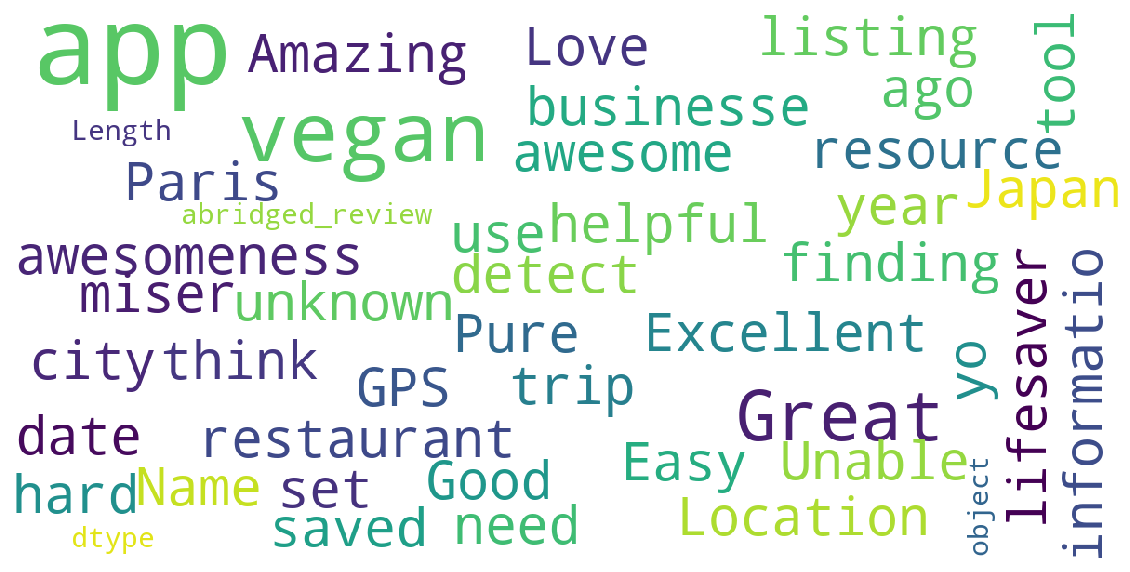

In [151]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_full['abridged_review'])

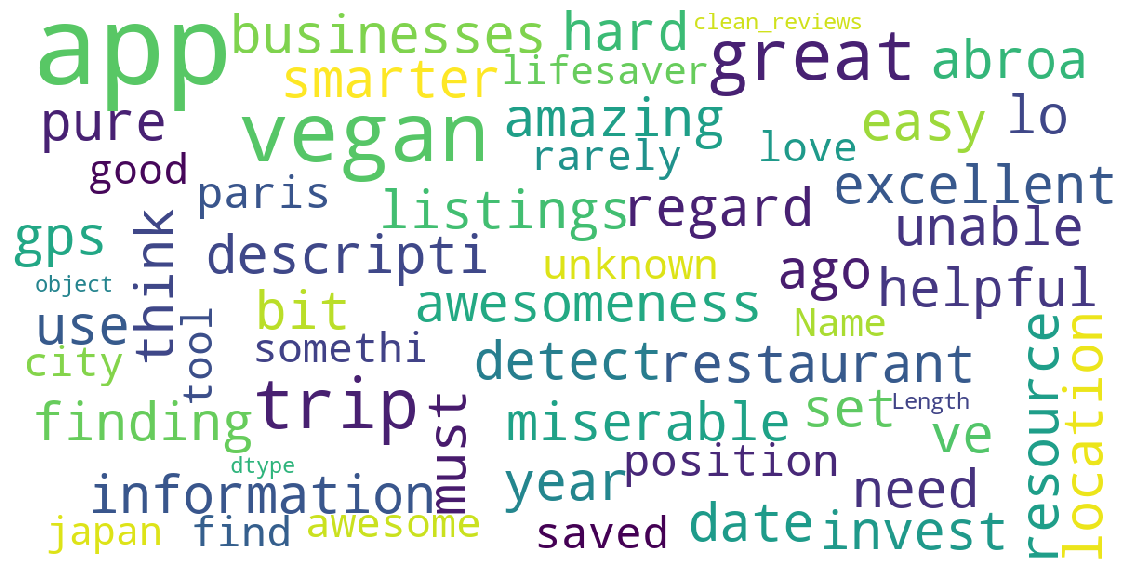

In [152]:
show_wordcloud(df_full['clean_reviews'])

In [153]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 105 entries, name to word_years
dtypes: datetime64[ns](2), float64(97), int8(1), object(5)
memory usage: 162.8+ KB


In [0]:
df_full['day'] = df_full['review_date'].dt.day
df_full['week'] = df_full['review_date'].dt.week
df_full['month'] = df_full['review_date'].dt.month
df_full['hour'] = df_full['review_date'].dt.hour
df_full['year'] = df_full['review_date'].dt.year

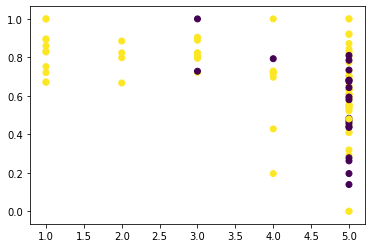

In [100]:
plt.scatter(df_full['stars'],df_full['review_neu'],c=df_full['year'])

In [155]:
df_full[['name','stars','review_compond','year','month']].sort_values(['review_compond'],ascending=False)

,name,stars,review_compond,year,month
60,Nancy Villanueva,5,0.9798,2019,4
52,A Google user,5,0.9752,2018,10
27,Dr. David Otto,5,0.9564,2019,7
62,Jennifer Klomp,3,0.9561,2019,4
188,Sarita Makam,5,0.9538,2018,8
...,...,...,...,...,...
10,Nils Grønkjær,1,-0.7469,2019,10
70,Julie Chmielecki,1,-0.7650,2019,5
25,Edward Blau,1,-0.7887,2019,8
42,Christy Johnson,1,-0.8061,2019,8


,year,month,stars,review_compond
0,2018,4,5.000000,0.759850
1,2018,5,5.000000,0.695260
2,2018,6,3.000000,0.844200
3,2018,7,5.000000,0.619650
4,2018,8,4.000000,0.480600
5,2018,9,4.833333,0.819783
6,2018,10,5.000000,0.935800
7,2018,11,5.000000,0.826650
8,2019,2,5.000000,0.555350
9,2019,3,4.000000,0.720450


In [156]:
star_analysis = df_full[['name','stars','review_compond','year','month']].groupby(by=['year','month'], as_index=False)['stars','review_compond'].agg(np.mean)

star_analysis.head()

,year,month,stars,review_compond
0,2018,7,4.166667,0.487367
1,2018,8,4.000000,0.386780
2,2018,9,4.000000,0.489675
3,2018,10,3.666667,0.425367
4,2018,11,4.307692,0.463869


In [157]:
star_analysis = star_analysis.assign(date=pd.to_datetime(star_analysis[['year', 'month']].assign(day=1)))

star_analysis.head()

,year,month,stars,review_compond,date
0,2018,7,4.166667,0.487367,2018-07-01
1,2018,8,4.000000,0.386780,2018-08-01
2,2018,9,4.000000,0.489675,2018-09-01
3,2018,10,3.666667,0.425367,2018-10-01
4,2018,11,4.307692,0.463869,2018-11-01


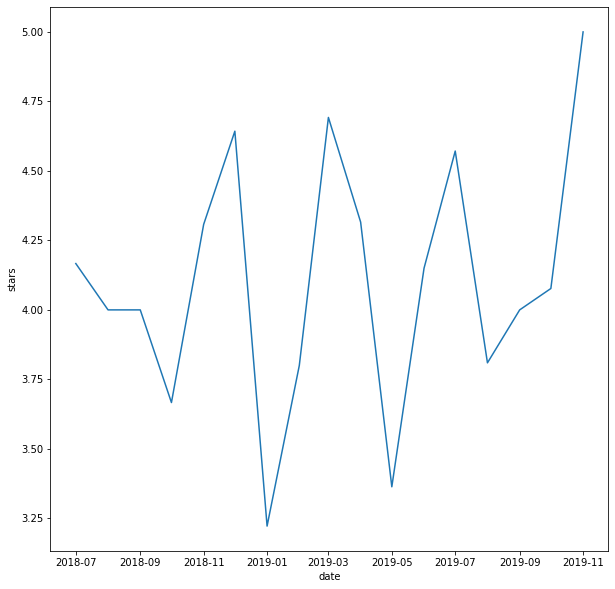

In [158]:
plt.figure(figsize=(10,10))
sns.lineplot(data=star_analysis,x = 'date', y = 'stars')

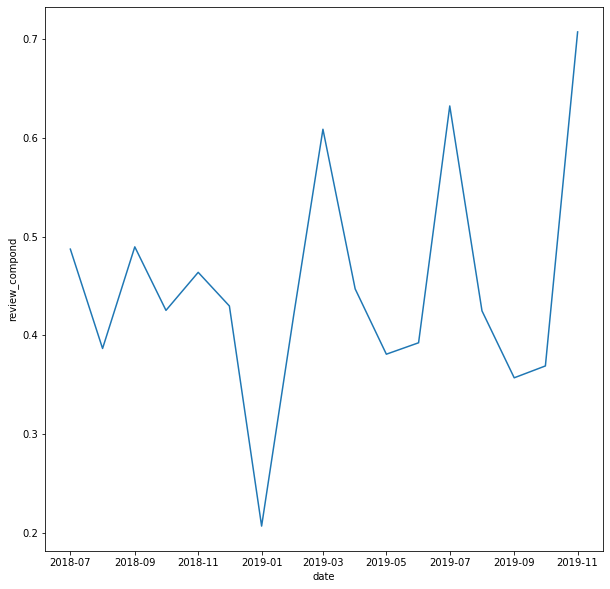

In [159]:
plt.figure(figsize=(10,10))
sns.lineplot(data=star_analysis,x = 'date', y = 'review_compond')

In [160]:
df_full.query('year==2019 & month==11')

,name,review_date,abridged_review,helpful_review,stars,response_date,response_text,clean_reviews,clean_response,review_neg,review_neu,review_pos,review_compond,word_also,word_always,word_amazing,word_app,word_away,word_awesome,word_back,word_best,word_better,word_can,word_city,word_could,word_cow,word_easier,word_easy,word_eat,word_eating,word_even,word_every,word_excellent,word_find,word_finding,word_food,word_found,word_free,word_friendly,word_full,...,word_reviews,word_search,word_see,word_star,word_stars,word_still,word_thank,word_thanks,word_thing,word_time,word_times,word_travel,word_traveling,word_travelling,word_tried,word_uninstalled,word_update,word_use,word_used,word_useful,word_ve,word_veg,word_vegan,word_vegans,word_vegetarian,word_version,word_way,word_well,word_wish,word_without,word_work,word_works,word_world,word_would,word_years,day,week,month,hour,year
0,Emily Ridgeway-Clarke,2019-11-12,Amazing app with up to date restaurant listing...,2.0,5,2019-11-15,Thanks Emily! We appreciate your kind words 😊🐮,amazing app date restaurant listings descripti...,thanks emily appreciate kind words 😊🐮,0.0,0.753,0.247,0.8478,0.0,0.0,0.327756,0.150360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.340802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411289,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.334046,0.000000,0.36472,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374325,0.0,0.0,12,46,11,0,2019
2,Tracey Nyholt,2019-11-14,Great App. Easy to use with helpful informatio...,NaN,5,2019-11-15,We are happy to help on your travels! Thanks f...,great app easy use helpful information must ve...,happy help travels thanks support tracey 🐮💜,0.0,0.498,0.502,0.8777,0.0,0.0,0.000000,0.161881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374771,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.403006,0.000000,0.0,0.0,0.0,0.0,0.310916,0.000000,0.000000,0.00000,0.0,0.000000,0.414567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,14,46,11,0,2019
3,BernaDette Session,2019-11-09,Excellent resource for finding vegan businesse...,2.0,5,2019-11-12,Thanks for the 5 star review BernaDette! 🐮💜,excellent resource finding vegan businesses lo...,thanks star review bernadette 🐮💜,0.0,0.543,0.457,0.8779,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.507915,0.0,0.45523,0.0,0.0,0.0,0.0,0.0,...,0.435758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.525884,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.261437,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9,45,11,0,2019
5,Ganesh Chandrasekaran,2019-11-08,"Very useful, they do worldwide. Very use ful w...",3.0,5,2019-11-12,We are happy to help you on your travels! Than...,useful worldwide use ful travel non english sp...,happy help travels thanks part community 😊🐮,0.0,0.824,0.176,0.4927,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.661385,0.000000,0.0,0.0,0.0,0.0,0.510254,0.000000,0.549737,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8,45,11,0,2019
34,Shmuel Steinberg,2019-11-10,Makes being vegan easy.,NaN,5,2019-06-27,"Wow, that is great to hear! We are happy to he...",makes vegan easy,wow great hear happy help find awesome veg foo...,0.0,0.508,0.492,0.4404,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623944,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.366494,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,10,45,11,0,2019


In [103]:
df_full.query('year==2019 & month==11')[['name','abridged_review','stars','review_compond']]

,name,abridged_review,stars,review_compond
91,Sibel Şendere,I reviewed 10 vegan products and this app dona...,5,0.0
92,Mohd azman Bin omar,O.K.,4,0.0


In [161]:
df_full.query('year==2019 & (month==6 | month==7)')\
[['month','name','abridged_review','clean_reviews','stars','review_compond']]\
.sort_values(by=['month','stars'],ascending=[True, False])

,month,name,abridged_review,clean_reviews,stars,review_compond
35,6,Aurijus Trikšys,Been using this app for years and it's helpful...,using app years helpful pretty much every corn...,5,0.7424
36,6,Brian Heess,Perfect for for finding what you want!,perfect finding want,5,0.6476
44,6,Dora Avila,Its amazing!!! Love all the options.,amazing love options,5,0.8713
45,6,Snorre Morten Kjeldsen,Amazingly useful!! A must-have app!,amazingly useful must-have app,5,0.6211
57,6,JJP ! !,this is a very good app for people🙌i love it! ...,good app people🙌i love makes easy vegan easy😃🌱🌍🙌🤙,5,0.9036
92,6,Matthew Tinker,Good app that performs an important purpose,good app performs important purpose,5,0.5719
99,6,P C,app works just fine now,app works fine,5,0.2023
122,6,Andrew S,Brilliant for vegans who are in new places and...,brilliant vegans new places need find tasty food,5,0.5859
139,6,gurri D,Got tasty food to eat with directions.,got tasty food eat directions,5,0.0000
154,6,lester lester,pls make iphone app free i HUNGRY,pls make iphone app free hungry,5,0.5574
